# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

* https://github.com/Luchkata/Algorithmic_Trading_Machine_Learning/blob/main/Algorithmic_Trading_Machine_Learning_Quant_Strategies.ipynb

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-06-11'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list, 
                 start=start_date, 
                 end=end_date).stack()

print('df')
print(df)
print('sp500')
print(sp500)
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


df
Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2016-06-13 A        42.807175   44.919998   45.520000   44.910000   45.320000   
           AAL      30.560539   31.799999   32.990002   31.639999   32.990002   
           AAPL     22.733387   24.334999   24.780001   24.275000   24.672501   
           ABBV     45.626972   59.930000   61.389999   59.849998   60.459999   
           ABT      34.102455   37.860001   38.549999   37.849998   38.320000   
...                       ...         ...         ...         ...         ...   
2024-06-10 XYL     139.250000  139.250000  139.250000  136.570007  136.929993   
           YUM     137.809998  137.809998  140.270004  137.690002  139.880005   
           ZBH     112.879997  112.879997  113.250000  111.440002  112.830002   
           ZBRA    302.600006  302.600006  303.769989  295.079987  298.820007   
           ZTS     178.83

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-13 A        42.807175   44.919998   45.520000   44.910000   45.320000   
           AAL      30.560539   31.799999   32.990002   31.639999   32.990002   
           AAPL     22.733387   24.334999   24.780001   24.275000   24.672501   
           ABBV     45.626972   59.930000   61.389999   59.849998   60.459999   
           ABT      34.102455   37.860001   38.549999   37.849998   38.320000   
...                       ...         ...         ...         ...         ...   
2024-06-10 XYL     139.250000  139.250000  139.250000  136.570007  136.929993   
           YUM     137.809998  137.809998  140.270004  137.690002  139.880005   
           ZBH     112.879997  112.879997  113.250000  111.440002  112.830002   
           ZBRA    302.600006  302.600006  303.769989  295.079987  298.820007   
           ZTS     178.830002  178.830002  179.759995  176.020004  176.570007   

Price                   volume  
date       ticker               
2016-06-13 A         1272800.0  
           AAL       9225600.0  
           AAPL    152082000.0  
           ABBV     11673600.0  
           ABT      11065900.0  
...                        ...  
2024-06-10 XYL       1304100.0  
           YUM       1717000.0  
           ZBH       1214500.0  
           ZBRA       227800.0  
           ZTS       2506900.0  

[992724 rows x 6 columns]

In [2]:
# https://help.yahoo.com/kb/SLN28256.html
# Adj closeは該当するすべての株式分割および配当分配を調整した後の終値です。
# データは、証券価格研究センター (CRSP) の標準に準拠し、適切な株式分割および配当乗数を使用して調整されます。

# https://breakingdownfinance.com/finance-topics/risk-management/garman-klass-volatility/
# https://portfolioslab.com/tools/garman-klass
# Garman Klass は、証券の始値、安値、高値、終値を組み込んだボラティリティ推定式です。
# 欠点はあるものの、Garman-Klass 推定値は、時間間隔の開始時と終了時の価格だけでなく、日中の価格の極値も考慮するため、基本的な式よりも効果的です。
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# RSIとは、「Relative Strength Index」の略で、テクニカルチャートのひとつです。日本語に訳すと「相対力指数」になります。買われすぎか、売られすぎかを判断するための指標として利用されています。
# RSIは、過去一定期間の上げ幅（前日比）の合計を、同じ期間の上げ幅の合計と下げ幅の合計を足した数字で割って、100を掛けたものです。
# いくら値上がり、値下がりしたかはRSIでは判断できません。数値は0～100で表され、一般的に70～80％以上で買われすぎ、20～30％以下で売られすぎと判断されます。
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# ボリンジャーバンドとは、移動平均線とその上下2本ずつの標準偏差からなる線の計5本の線で表わされます。英字表記は「Bollinger bands」となります。
# ボリンジャーバンドは統計学を使って作られていて、大まかにいうと、高い確率で＋2σ(標準偏差)と－2σのラインの間で価格は動くだろうという予測をもとに将来の価格の動きを予測するために使います。
# なお、統計学上、＋2σと－2σの間に収まる確率は95.45%とされています。
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# 「相場の変動率」を解析する指標（計算式）が「ATR（アベレージトゥルーレンジ)」です。 相場の変動が大きい傾向なのか小さい傾向なのかを分析する場合に有効です。 
# 「当日高値-当日安値」「当日高値-前日終値」「当日安値-前日終値」の3つのうち最大の値幅(マド明けを含む最大値幅の計測)を当日の「真の値幅(トゥルーレンジ)」と呼び、
# この「真の値幅」の移動平均線がATR(アベレージトゥルーレンジ)です。
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
             low=stock_data['low'],
             close=stock_data['close'],
             length=14)
    return atr.sub(atr.mean()).div(atr.std())
    
# 今回と関係ないけど日本語でATR出したりと似たようなことしている記事あった　　https://qiita.com/__x__/items/ed91e995aec21ac89c8b
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# MACD（通称マックディー）は、移動平均の発展版で、更に売買シグナルにおいて精度を高くした、トレンド分析の中でも人気のある指標の一つです。
# 「移動平均収束拡散」又は「移動平均収束乖離」などとも呼ばれています。トレンド形成時に威力を発揮するため、逆にボックス相場に弱いのが特徴です。
# 主にMACDとMACDシグナルという2本のラインの交差を売買のタイミングとして用いられることが多く、初心者の方でもシグナルの発見が容易です。
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# １００万株取引されることがわかっているので1e6で割る(?)
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-13 A        42.807175   44.919998   45.520000   44.910000   45.320000   
           AAL      30.560539   31.799999   32.990002   31.639999   32.990002   
           AAPL     22.733387   24.334999   24.780001   24.275000   24.672501   
           ABBV     45.626972   59.930000   61.389999   59.849998   60.459999   
           ABT      34.102455   37.860001   38.549999   37.849998   38.320000   
...                       ...         ...         ...         ...         ...   
2024-06-10 XYL     139.250000  139.250000  139.250000  136.570007  136.929993   
           YUM     137.809998  137.809998  140.270004  137.690002  139.880005   
           ZBH     112.879997  112.879997  113.250000  111.440002  112.830002   
           ZBRA    302.600006  302.600006  303.769989  295.079987  298.820007   
           ZTS     178.830002  178.830002  179.759995  176.020004  176.570007   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-13 A         1272800.0         -0.001166        NaN       NaN   
           AAL       9225600.0         -0.001388        NaN       NaN   
           AAPL    152082000.0         -0.002376        NaN       NaN   
           ABBV     11673600.0         -0.030284        NaN       NaN   
           ABT      11065900.0         -0.005084        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-10 XYL       1304100.0          0.000080  53.247770  4.916954   
           YUM       1717000.0          0.000086  49.052981  4.908047   
           ZBH       1214500.0          0.000130  34.551463  4.716477   
           ZBRA       227800.0          0.000360  46.634822  5.705730   
           ZTS       2506900.0          0.000159  63.311220  5.123798   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-06-13 A            NaN       NaN       NaN       NaN      54.484972  
           AAL          NaN       NaN       NaN       NaN     281.939311  
           AAPL         NaN       NaN       NaN       NaN    3457.338961  
           ABBV         NaN       NaN       NaN       NaN     532.631023  
           ABT          NaN       NaN       NaN       NaN     377.374358  
...                     ...       ...       ...       ...            ...  
2024-06-10 XYL     4.957580  4.998206  0.934388  0.047207     181.595925  
           YUM     4.938344  4.968642  0.539870  0.033923     236.619766  
           ZBH     4.766735  4.816993 -0.825106 -0.953872     137.092757  
           ZBRA    5.758481  5.811232 -0.089996 -0.208410      68.932281  
           ZTS     5.156542  5.189286  0.583575  0.989987     448.308932  

[992724 rows x 14 columns]

# Aggregate to monthly level and filter top 150 most liquid stocks for each month.

トレーニング時間を短縮し、機能や戦略を実験するために、毎日の営業データを月末の頻度に変換します。
To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [3]:
# ここから列の並び順が動画と違う？書いてる内容は同じなはずだが・・・
# doller volumeは各銘柄の月全体の平均調整後価格を出したいらしい

# 別にuniqueにしなくても良さそうだけどしてるみたい。
# 全データが日時なため、日時→月次にしたいらしい。
# OHLCとは（Open/High/Low/Close）の省略表記で、ローソク足の価格データセット（始値・高値・安値・終値）である。ここに出来高（Volume）を加え、OHLCVで提供されることも多い。
# OHLCは要らないらしくテクニカル指標を指定したいらしい。インジケーターは列を指定する必要があるのでインジケータ
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

# 時系列データを元データより高い頻度または低い頻度で再度サンプリングすることをリサンプリングと呼ぶ。MはMonthly
# 今は日時がスタックしているdfをticker単位でunstackして、dollar_volumeとテクニカル指標をそれぞれ月次にresampleして、dollar_volumeは平均を出しつつ、
# テクニカル指標はlastで月末の値をシンプルに指定しつつstackし直す
# dropnaは欠損値を落とす
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
# ソート順が揃わないので無理やり揃えることにした→揃えたらStrategy returnが良くなった！
# 指定されたカラム順
column_order = ['dollar_volume', 'adj close', 'atr', 'bb_high', 'bb_low', 'bb_mid', 'garman_klass_vol', 'macd', 'rsi']

# カラムを指定された順序に並べ替える
data = data[column_order]

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-07-31 A           76.638947   45.967949 -1.322872  3.858446  3.761786   
           AAL        401.105337   34.116333  0.659455  3.684955  3.334677   
           AAPL      3171.429984   24.337851 -1.225549  3.229708  3.127196   
           ABBV       376.154237   50.866047 -1.359537  3.944017  3.879581   
           ABT        421.087535   40.556923 -1.212081  3.736831  3.603767   
...                          ...         ...       ...       ...       ...   
2024-06-30 XYL        181.697911  139.250000  0.934388  4.998206  4.916954   
           YUM        242.787622  137.809998  0.539870  4.968642  4.908047   
           ZBH        131.137381  112.879997 -0.825106  4.816993  4.716477   
           ZBRA        68.677808  302.600006 -0.089996  5.811232  5.705730   
           ZTS        362.314871  178.830002  0.583575  5.189286  5.123798   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-07-31 A       3.810116         -0.000263  0.231111  65.740746  
           AAL     3.509816         -0.000845  2.685472  60.343834  
           AAPL    3.178452         -0.001745 -0.057383  68.694454  
           ABBV    3.911799         -0.023835  0.362195  71.459401  
           ABT     3.670299         -0.002950  1.049502  79.794886  
...                     ...               ...       ...        ...  
2024-06-30 XYL     4.957580          0.000080  0.047207  53.247770  
           YUM     4.938344          0.000086  0.033923  49.052981  
           ZBH     4.766735          0.000130 -0.953872  34.551463  
           ZBRA    5.758481          0.000360 -0.208410  46.634822  
           ZTS     5.156542          0.000159  0.989987  63.311220  

[47364 rows x 9 columns]

In [4]:
# Calculate 5-year rolling average of dollar volume for each stocks before filtering.
# それを下に各月のもっとも流動性の高い１５０種類をピックアップしたいらしい

# ローリング平均では、データ・セットの平均が継続的に更新され、その時点までのデータすべてが算入されます。
# 例えば、2012 年 3 月の返品数量のローリング平均は、1 月、2 月、3 月の返品数量を加算し、その合計を 3 で除算して計算されます。
# locは行名もしくは列名を指定することで特定の値を抽出できます。（行名や列名をラベルと置き換えて頂いても問題ありません。）
# ilocはindexを指定することで特定の値を抽出できます。つまり、行、列を番号（数字が０のインデックス）で指定します。

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-06-30 AAL      48.838978  0.514358  3.923412  3.858654  3.891033   
           AAPL     34.279442 -1.093698  3.636000  3.532151  3.584076   
           ABBV     57.334557 -1.534226  4.090591  3.995286  4.042939   
           ABT      44.894611 -1.340555  3.851552  3.776354  3.813953   
           ACN     115.219536 -1.103126  4.800320  4.737649  4.768984   
...                       ...       ...       ...       ...       ...   
2024-06-30 VZ       40.410000 -0.636822  3.755567  3.688393  3.721980   
           WFC      57.930000 -0.090024  4.152946  4.066215  4.109581   
           WMT      66.959999  1.274662  4.250956  4.117645  4.184301   
           XOM     113.080002  0.734529  4.797338  4.718381  4.757859   
           ZTS     178.830002  0.583575  5.189286  5.123798  5.156542   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-06-30 AAL            -0.000020  0.683485  59.919036  
           AAPL           -0.001015 -0.455605  43.606613  
           ABBV           -0.021416  0.428388  71.506120  
           ABT            -0.002621  0.483373  67.057288  
           ACN            -0.001724 -0.187673  49.971688  
...                             ...       ...        ...  
2024-06-30 VZ              0.000051  0.525412  50.908533  
           WFC             0.000086 -0.539630  43.987099  
           WMT             0.000121  2.729681  68.261042  
           XOM             0.000090 -0.978523  44.300944  
           ZTS             0.000159  0.989987  63.311220  

[12665 rows x 8 columns]

# 4.calculate monthly returns for different time horizons as features
To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.
例えば、モメンタムパターンを反映する時系列ダイナミクスを捉えるために、ラグで特定される様々な月次期間のリターンを計算する、 
.pct_change(lag)という方法で過去のリターンを計算する、すなわち、様々な月次期間のリターンをラグで識別する。
↑訳してもわからん

時間軸で分けたいろいろなデータを取ることで該当銘柄のモメンタムを見れるらしい

In [5]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        # diff()がA - Bで差分を算出するのに対し、pct_change()は(A - B) / Bで変化率を算出する。
        # 3^4 = 3 ** 4 = pow(3,4) その結果は冪 (べき、英: power) と呼ばれる。表現の揺れにより同じ概念は日本語で「累乗」とも表現されている
        # 四分位数とは、データを大きさの順に並べて、個数を４等分できる値のことです。森からうさぎを40羽連れてきて、体の大きさ順に並べます。
        # うさぎをピッタリ４等分できる線は、10と11番目の間、20と21番目の間、30と31番目の間の線になります。これが四分位数です。
        # pipe.clip 外れ値を四分位範囲を用いてクリップする https://ensekitt.hatenablog.com/entry/2018/02/13/200000
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-06-30 AAL      37.156174  0.680197  3.838545  3.636104  3.737324   
           AAPL     44.744537 -1.033822  3.878383  3.803339  3.840861   
           ABBV     75.744133 -0.288749  4.447032  4.321698  4.384365   
           ABT      57.464638 -0.967903  4.118919  4.059346  4.089132   
           ACN     155.233322 -0.639088  5.068323  5.004734  5.036528   
...                       ...       ...       ...       ...       ...   
2024-06-30 VRTX    483.279999  1.343660  6.199735  6.041801  6.120768   
           VZ       40.410000 -0.636822  3.755567  3.688393  3.721980   
           WFC      57.930000 -0.090024  4.152946  4.066215  4.109581   
           WMT      66.959999  1.274662  4.250956  4.117645  4.184301   
           XOM     113.080002  0.734529  4.797338  4.718381  4.757859   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-06-30 AAL            -0.000030 -1.702144  30.484783  -0.128158   
           AAPL           -0.000352 -0.321160  49.582405  -0.009418   
           ABBV           -0.015793 -1.190942  38.080531  -0.063574   
           ABT            -0.001651 -0.312252  47.018533  -0.008776   
           ACN            -0.001097  0.045384  58.053389   0.050404   
...                             ...       ...        ...        ...   
2024-06-30 VRTX            0.000086  3.917673  74.046090   0.061361   
           VZ              0.000051  0.525412  50.908533  -0.017983   
           WFC             0.000086 -0.539630  43.987099  -0.033211   
           WMT             0.000121  2.729681  68.261042   0.018248   
           XOM             0.000090 -0.978523  44.300944  -0.035647   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-06-30 AAL     -0.058566  -0.098656  -0.050518  -0.023882   -0.022526  
           AAPL     0.060393   0.034635   0.016401   0.021872    0.022450  
           ABBV    -0.020405  -0.003677  -0.004230   0.007379    0.023476  
           ABT      0.024305   0.007529   0.012748   0.016592    0.020784  
           ACN      0.040166   0.024443   0.012599   0.023607    0.025152  
...                      ...        ...        ...        ...         ...  
2024-06-30 VRTX     0.109196   0.049552   0.029091   0.037248    0.026788  
           VZ       0.011581  -0.012468   0.011637   0.024815    0.006944  
           WFC     -0.011786  -0.000173   0.027528   0.039549    0.025786  
           WMT      0.062178   0.036283   0.041215   0.025654    0.020653  
           XOM     -0.022187  -0.009145   0.020733  -0.004327    0.004421  

[10495 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas
Fama-French 5ファクターモデルとは、Fama-French 3ファクターモデルに、収益性（Profitability）と投資（Investment）のファクターを追加したモデルであり、下記式であらわされるモデルである。
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.
本論文では、線形回帰を用いて一般的なリスク要因に対する資産のエクスポージャーを推定するためのFama-Frenchデータを紹介する。
市場リスク、規模、バリュー、営業収益性、投資の5つのFama-Frenchファクターは、経験的に資産リターンを説明することが示されており、ポートフォリオのリスク／リターン・プロファイルを評価するために一般的に使用されている。したがって、過去のファクター・エクスポージャーを財務的特徴としてモデルに含めることは自然なことです。
pandas-datareader を使って過去のファクターリターンにアクセスし、RollingOLS のローリング線形回帰を使って過去のエクスポージャを推定することができます。

SMB (Small Minus Big) is the average return on the nine small stock portfolios minus the average return on the nine big stock portfolios,

HML (High Minus Low) is the average return on the two value portfolios minus the average return on the two growth portfolios,

RMW (Robust Minus Weak) is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios,

CMA (Conservative Minus Aggressive) is the average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios,

Rm-Rf, the excess return on the market, value-weight return of all CRSP firms incorporated in the US and listed on the NYSE, AMEX, or NASDAQ that have a CRSP share code of 10 or 11 at the beginning of month t, good shares and price data at the beginning of t, and good return data for t minus the one-month Treasury bill rate (from Ibbotson Associates).

SMB（Small Minus Big）は、9つの小型株ポートフォリオの平均リターンから 9 つの大型株ポートフォリオの平均リターンを差し引いたものです、
HML（High Minus Low）は、2つのバリュー・ポートフォリオの平均リターンから2つのグロース・ポートフォリオの平均リターンを差し引いたものです、
RMW（Robust Minus Weak）は、2つの強固な営業収益性ポートフォリオの平均リターンから2つの脆弱な営業収益性ポートフォリオの平均リターンを差し引いたものです、
CMA（Conservative Minus Aggressive）は、2つの保守的投資ポートフォリオの平均リターンから2つの積極的投資ポートフォリオの平均リターンを引いたものである、
Rm-Rfは、米国で設立され、NYSE、AMEX、またはNASDAQに上場しているすべてのCRSP企業のうち、t月初にCRSPの株式コードが10または11であり、t月初に良好な株式と価格のデータ、およびtの良好なリターンのデータから1ヶ月物国庫短期証券レートを差し引いた市場、バリューウェイトリターンの超過リターン（Ibbotson Associatesより）。

In [6]:
# Kenneth French's data library：ケネス・R・フレンチのHPがpandas_datareaderに対応しているっぽい
# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010'
              )[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050404
...                   ...     ...     ...     ...     ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.058866
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.017464

[10209 rows x 6 columns]

In [7]:
# 属性sizeで全要素数、属性shapeで形状（行数、列数）が取得できる。要素数が少ない銘柄を除外しているっぽい
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
# ここで「key1 が A の行だけフィルタリングしたい」という場合、どうすればいいか。→pandas.MultiIndex.get_level_values というメソッドを使うと、Multi-Index の値にアクセスできる。
# isin()メソッドは、リスト内の値が別のリストに含まれているかどうかをチェックするために利用します。リストの値をカンマで区切って指定し、リストの値が含まれている場合はTrue、含まれていない場合はFalseを返します。
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050404
...                   ...     ...     ...     ...     ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.058866
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.017464

[10176 rows x 6 columns]

In [8]:
# 最小二乗法 (OLS) は、最もよく知られている回帰分析手法です。これは、すべての空間回帰分析の開始点でもあります。
# 理解または予測しようとしている変数またはプロセスのグローバル モデルを作成し、そのプロセスを表す単一の回帰方程式を作成します。
# Rolling OLS applies OLS across a fixed windows of observations and then rolls (moves or slides) the window across the data set. 
# They key parameter is window which determines the number of observations used in each OLS regression. 
# By default, RollingOLS drops missing values in the window and so will estimate the model using the available data points.
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-06-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-04-30 VRTX    0.366069  0.640066 -0.678316  0.325818  0.739600
           VZ      0.417948 -1.028760  0.558246  0.065854 -0.070422
           WFC     1.087388  0.301427  1.207553 -0.467027 -0.763963
           WMT     0.612351  0.130705 -0.651859  0.638969  0.446877
           XOM     0.784157 -0.059518  0.654003  0.931625  0.340911

[10176 rows x 5 columns]

In [9]:
# 計算したbetasをもともとのdataに混ぜたいが、rolling factorは次の月末の結果を計算しておりそのままだと１ヶ月のズレが生じてしまうため、betasを一ヶ月早めてから(shift())混ぜる
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
# shift()デフォルトでは下方向に1行ずれる。行数はそのままなので、最後の行のデータは削除される。
data = (data.join(betas.groupby('ticker').shift()))

# 欠損値は平均値で埋める
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10284 entries, (Timestamp('2018-06-30 00:00:00'), 'AAL') to (Timestamp('2024-06-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10284 non-null  float64
 1   bb_high           10284 non-null  float64
 2   bb_low            10284 non-null  float64
 3   bb_mid            10284 non-null  float64
 4   garman_klass_vol  10284 non-null  float64
 5   macd              10284 non-null  float64
 6   rsi               10284 non-null  float64
 7   return_1m         10284 non-null  float64
 8   return_2m         10284 non-null  float64
 9   return_3m         10284 non-null  float64
 10  return_6m         10284 non-null  float64
 11  return_9m         10284 non-null  float64
 12  return_12m        10284 non-null  float64
 13  Mkt-RF            10284 non-null  float64
 14  SMB               10284 non-null  float64
 15  HML        

# 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features

In [10]:
# hypothesis: rsi 70 stock has stock momentum
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html 
# If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.
# centroid 【名】 《物理》質量中心
target_rsi_values = [30, 45, 55, 70]

initial_centeroids = np.zeros((len(target_rsi_values), 18))

# 6=rsi
initial_centeroids[:,6] = target_rsi_values

initial_centeroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [11]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centeroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-06-30 AAL     0.680197  3.838545  3.636104  3.737324         -0.000030   
           AAPL   -1.033822  3.878383  3.803339  3.840861         -0.000352   
           ABBV   -0.288749  4.447032  4.321698  4.384365         -0.015793   
           ABT    -0.967903  4.118919  4.059346  4.089132         -0.001651   
           ACN    -0.639088  5.068323  5.004734  5.036528         -0.001097   
...                     ...       ...       ...       ...               ...   
2024-06-30 VRTX    1.343660  6.199735  6.041801  6.120768          0.000086   
           VZ     -0.636822  3.755567  3.688393  3.721980          0.000051   
           WFC    -0.090024  4.152946  4.066215  4.109581          0.000086   
           WMT     1.274662  4.250956  4.117645  4.184301          0.000121   
           XOM     0.734529  4.797338  4.718381  4.757859          0.000090   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-06-30 AAL    -1.702144  30.484783  -0.128158  -0.058566  -0.098656   
           AAPL   -0.321160  49.582405  -0.009418   0.060393   0.034635   
           ABBV   -1.190942  38.080531  -0.063574  -0.020405  -0.003677   
           ABT    -0.312252  47.018533  -0.008776   0.024305   0.007529   
           ACN     0.045384  58.053389   0.050404   0.040166   0.024443   
...                     ...        ...        ...        ...        ...   
2024-06-30 VRTX    3.917673  74.046090   0.061361   0.109196   0.049552   
           VZ      0.525412  50.908533  -0.017983   0.011581  -0.012468   
           WFC    -0.539630  43.987099  -0.033211  -0.011786  -0.000173   
           WMT     2.729681  68.261042   0.018248   0.062178   0.036283   
           XOM    -0.978523  44.300944  -0.035647  -0.022187  -0.009145   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-30 AAL     -0.050518  -0.023882   -0.022526  1.210478  1.477898   
           AAPL     0.016401   0.021872    0.022450  1.320566 -0.351319   
           ABBV    -0.004230   0.007379    0.023476  0.463465  0.513030   
           ABT      0.012748   0.016592    0.020784  0.791149 -0.149617   
           ACN      0.012599   0.023607    0.025152  1.211803 -0.194953   
...                      ...        ...         ...       ...       ...   
2024-06-30 VRTX     0.029091   0.037248    0.026788  0.394621 -0.241341   
           VZ       0.011637   0.024815    0.006944  0.460912 -0.467221   
           WFC      0.027528   0.039549    0.025786  1.081359 -0.091196   
           WMT      0.041215   0.025654    0.020653  0.601528 -0.361310   
           XOM      0.020733  -0.004327    0.004421  1.079432  0.172624   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-30 AAL     0.439869  0.141818  0.818850        0  
           AAPL   -0.620947  0.440199  0.618728        2  
           ABBV   -0.203543  0.535098  0.434880        0  
           ABT    -0.448099  0.251665  0.939353        1  
           ACN    -0.261587  0.326683  0.100705        3  
...                     ...       ...       ...      ...  
2024-06-30 VRTX   -0.761477  0.294403  1.248280        3  
           VZ      0.206589  0.193983  0.252318        1  
           WFC     1.557811 -0.747387 -0.831912        1  
           WMT    -0.385552  0.317731  0.706135        3  
           XOM     0.809255 -0.469208  0.475872        1  

[10284 rows x 19 columns]

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    # scatter first column=atr, second column=rsi
    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    # 動画と自分の表の列の並び順が違うので書き換えちゃう→今は並び順を変えていないので書き換えないが記録を残す
    # 昔書き換えたやつ
    # plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    # plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    # plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    # plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

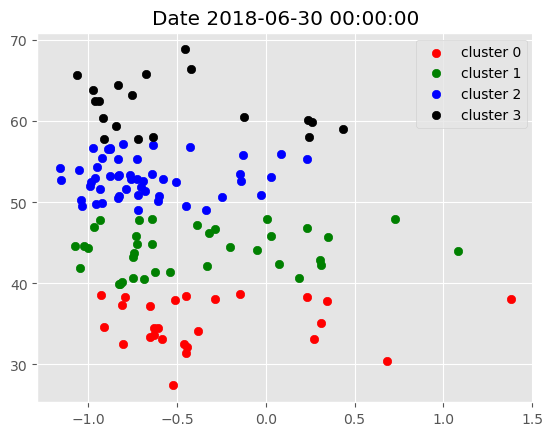

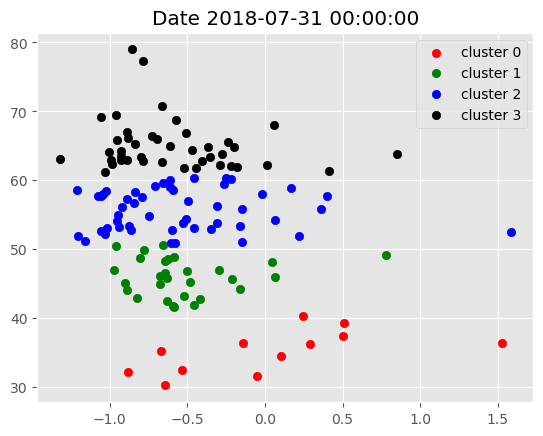

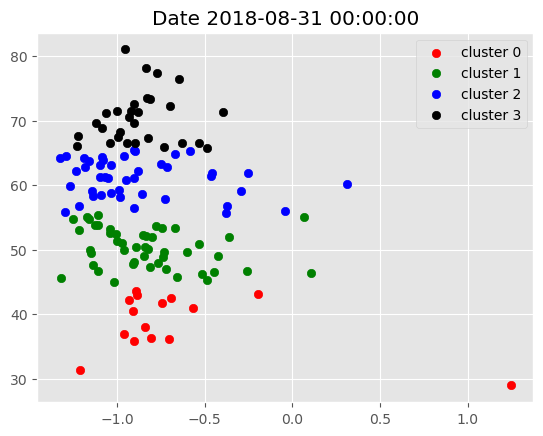

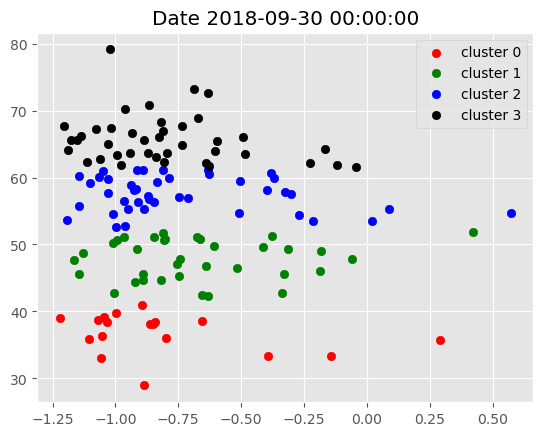

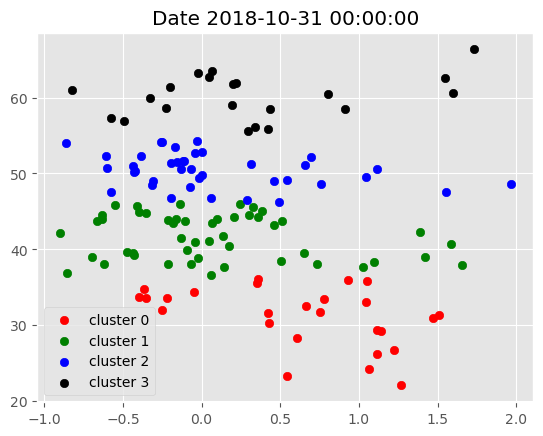

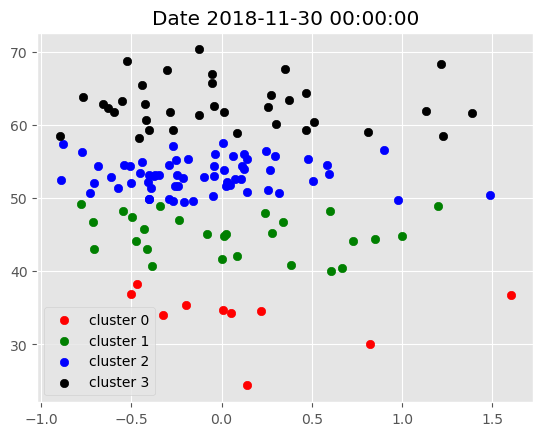

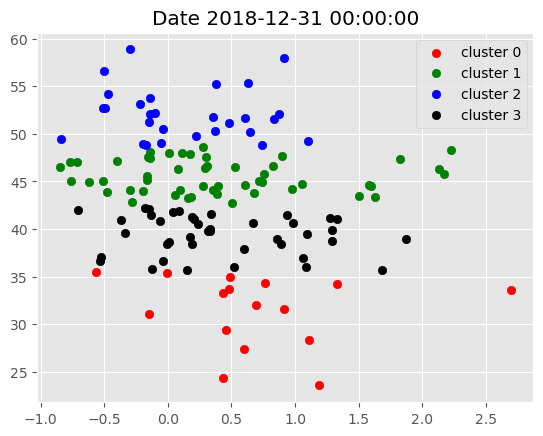

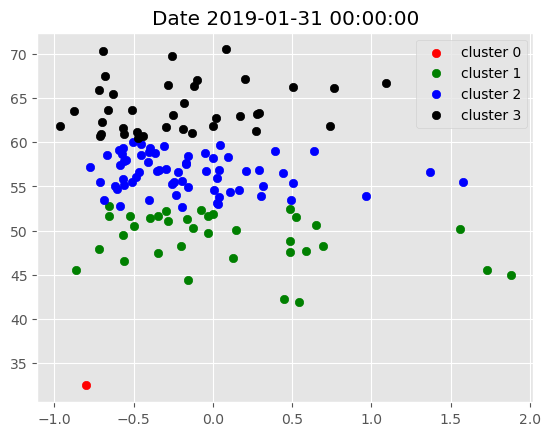

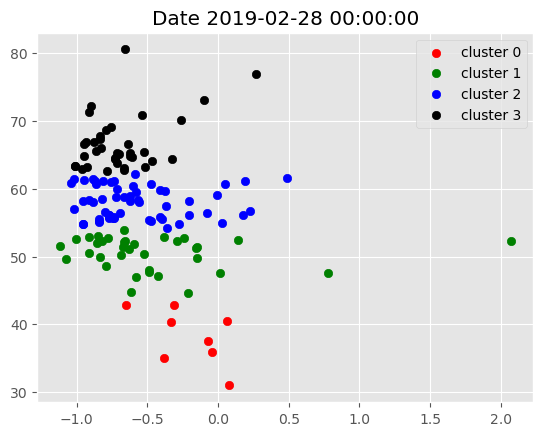

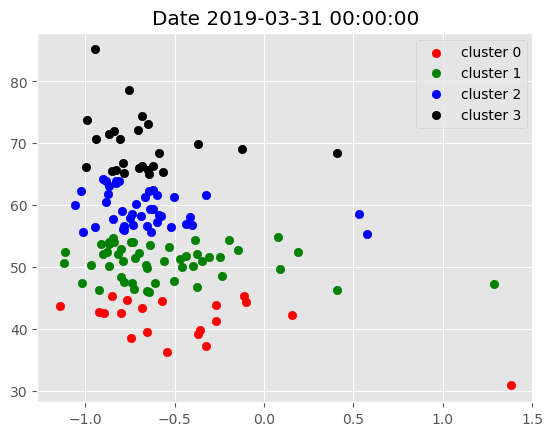

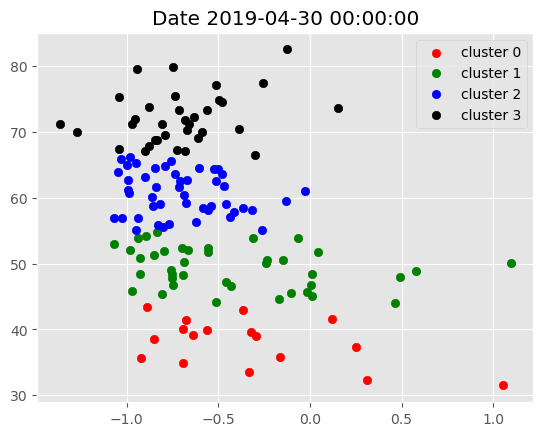

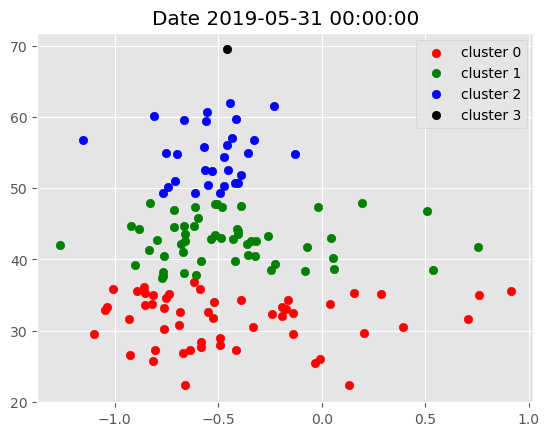

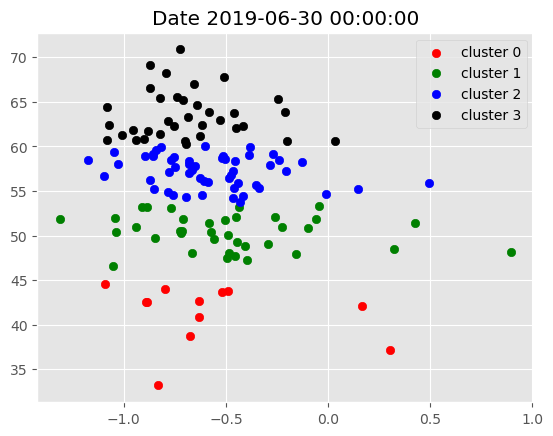

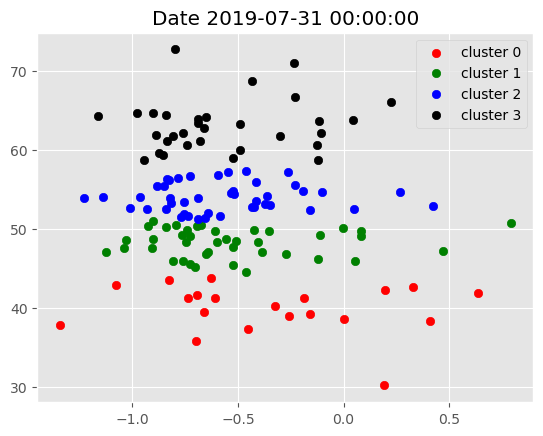

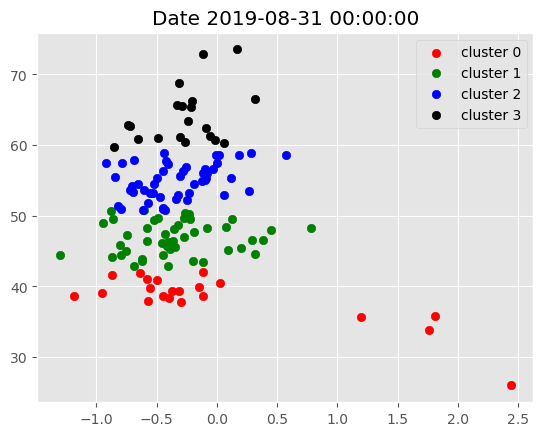

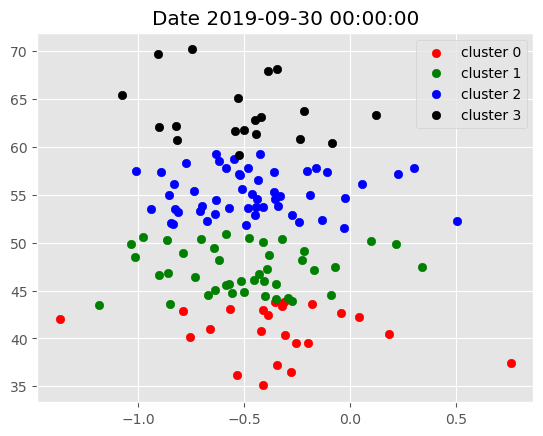

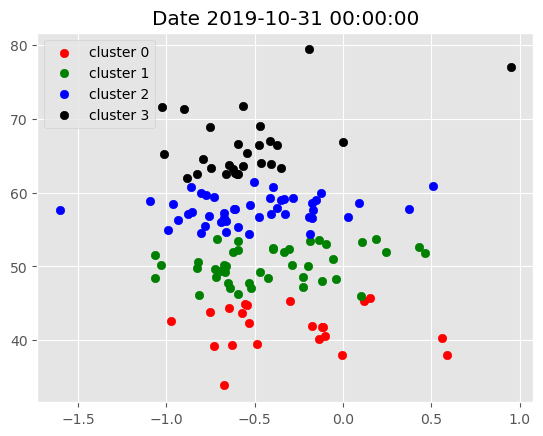

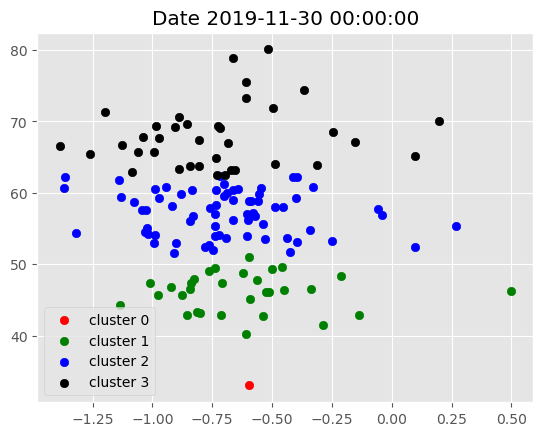

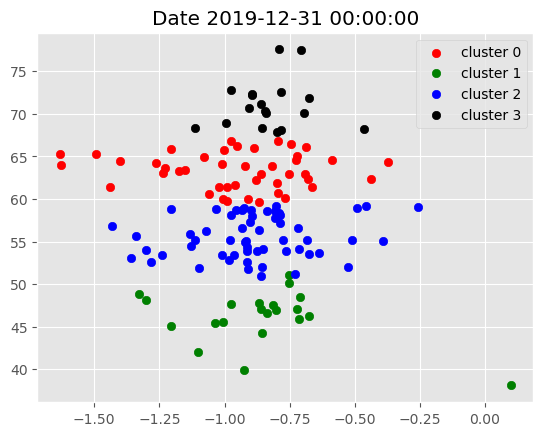

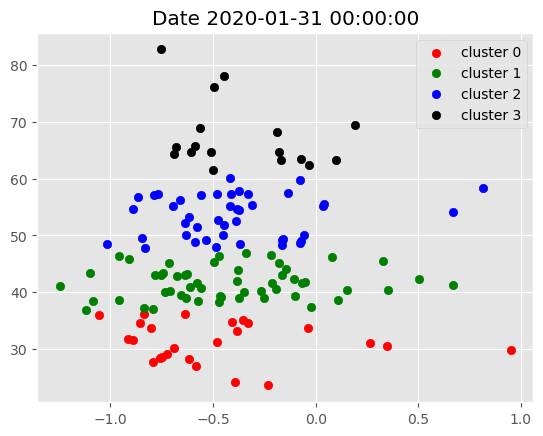

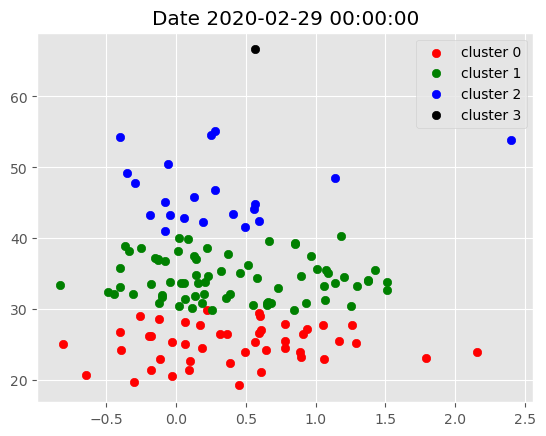

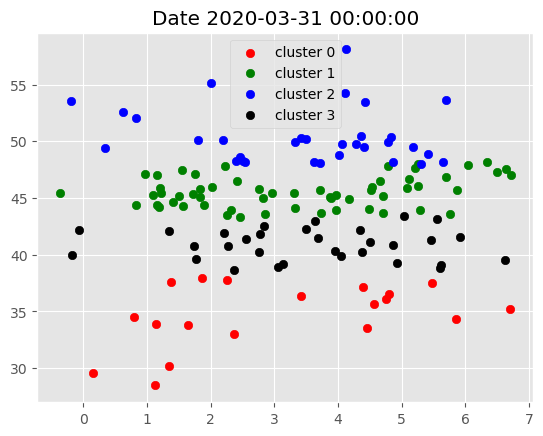

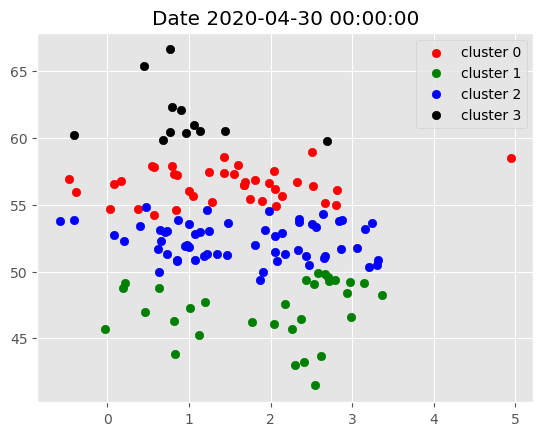

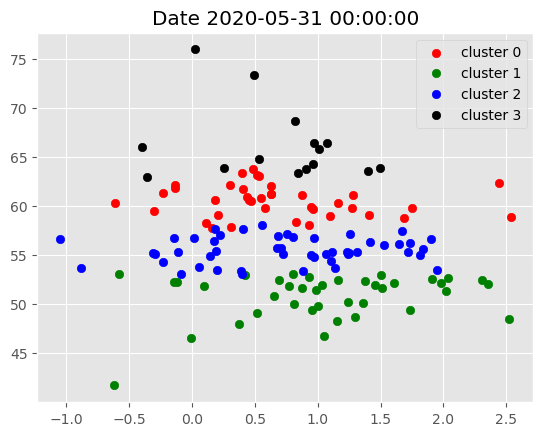

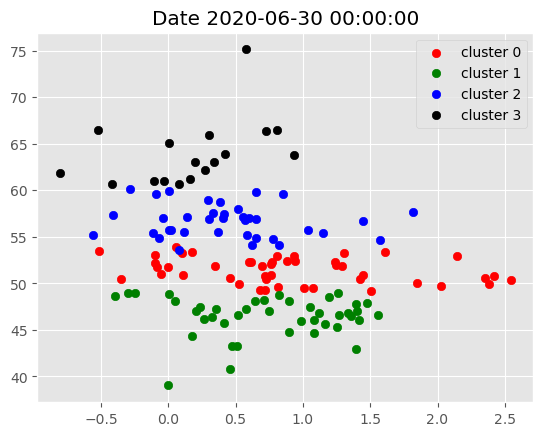

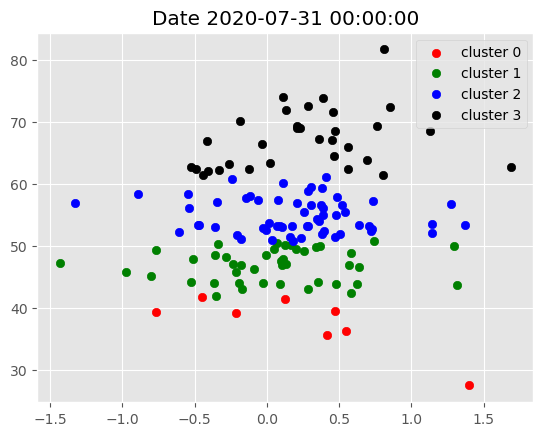

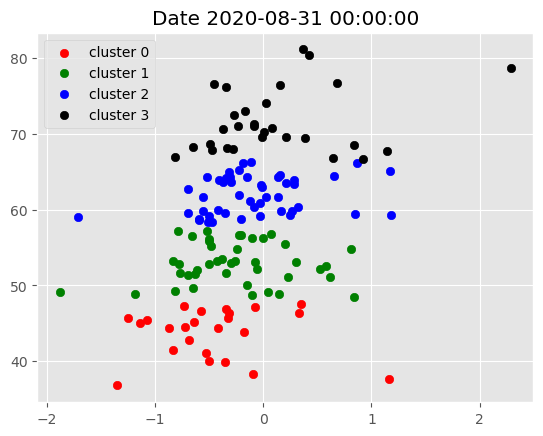

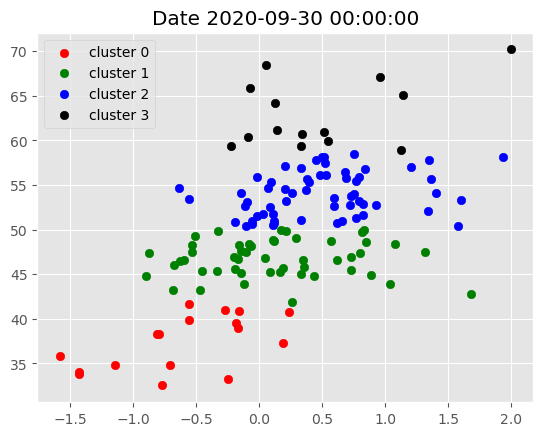

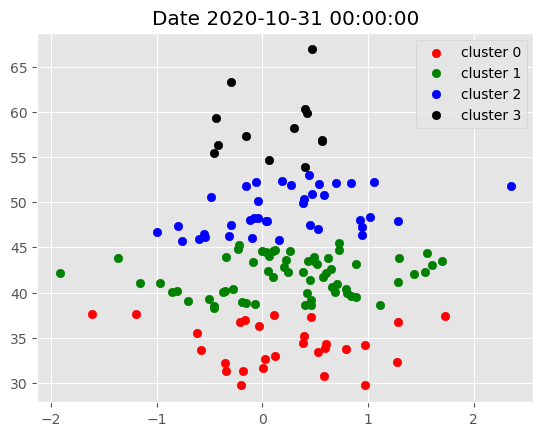

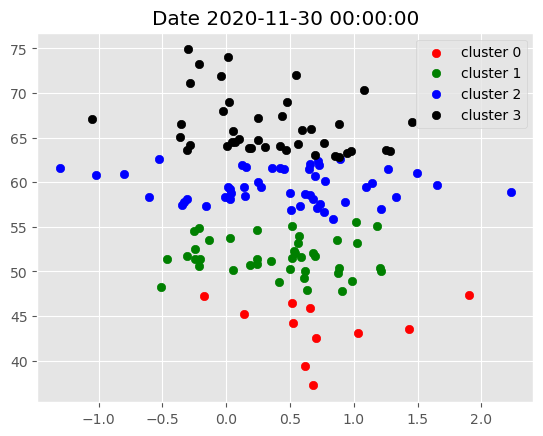

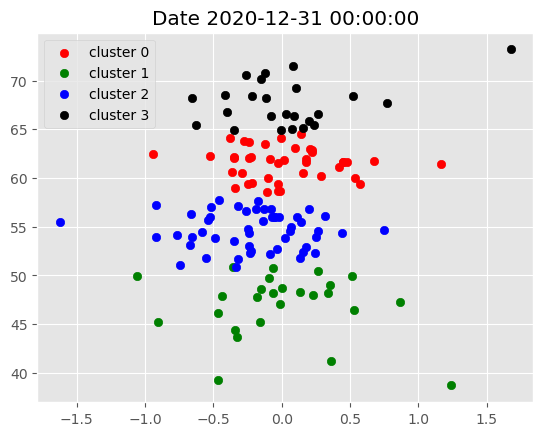

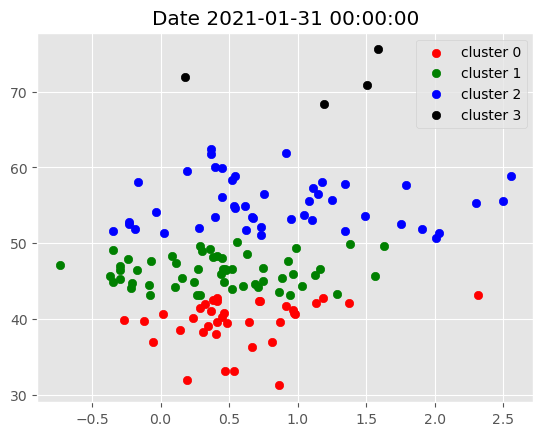

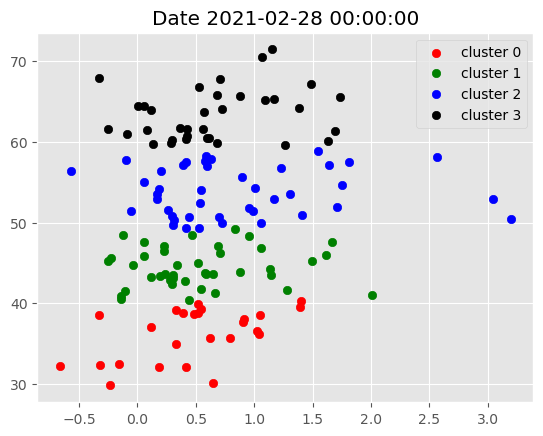

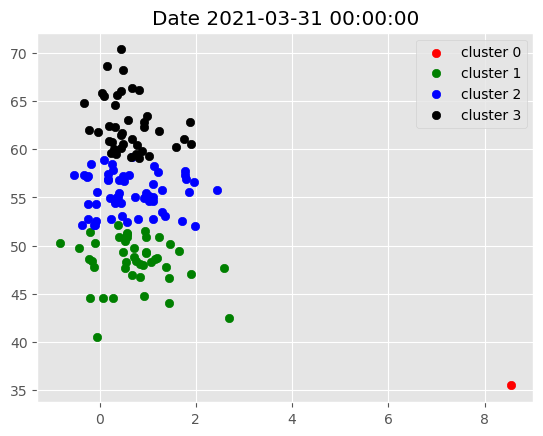

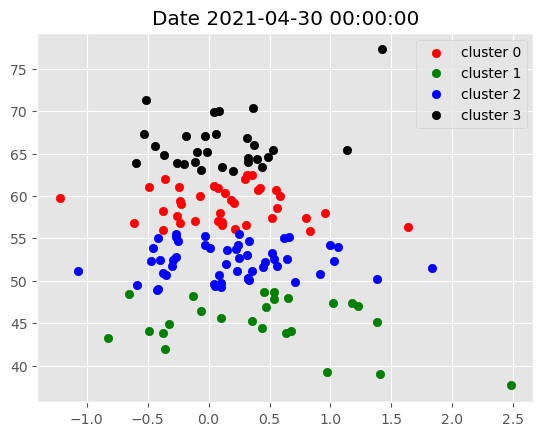

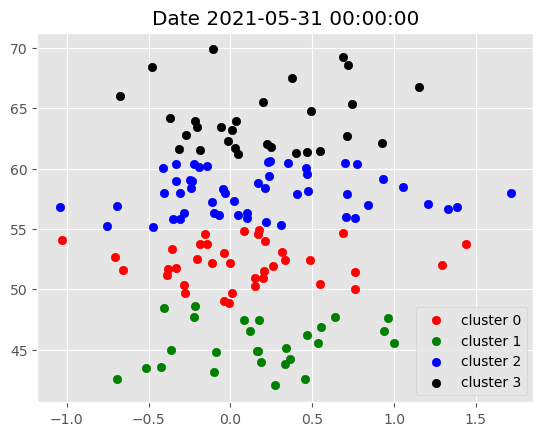

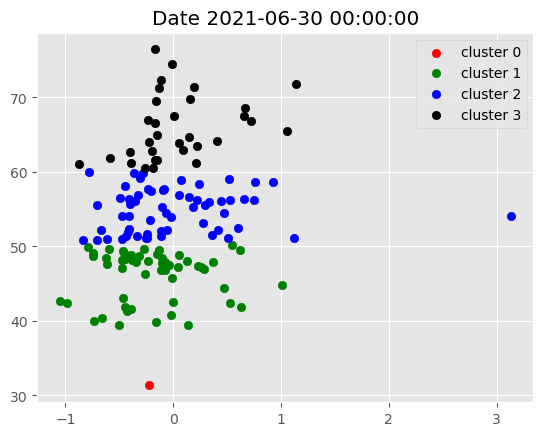

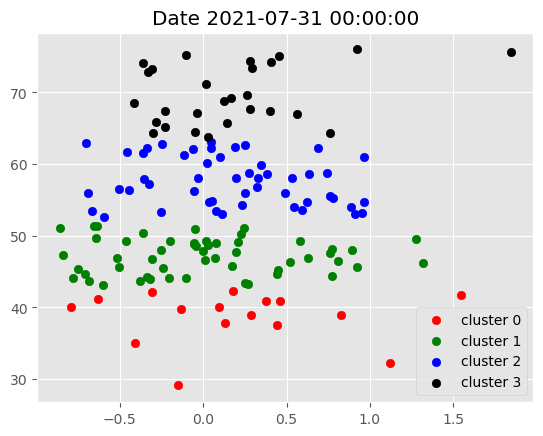

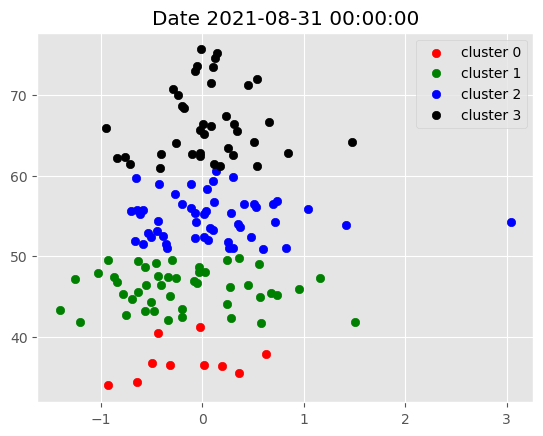

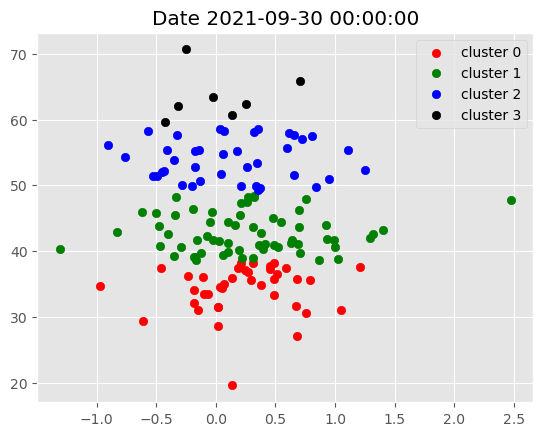

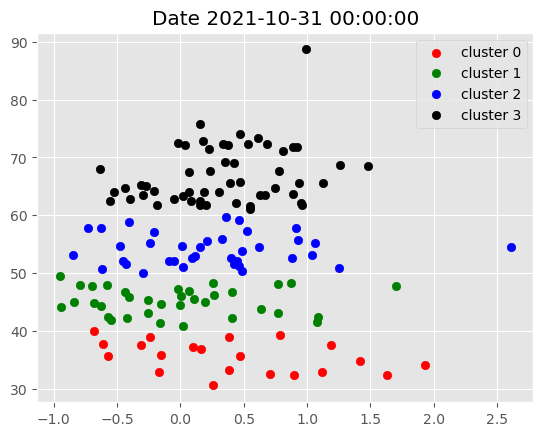

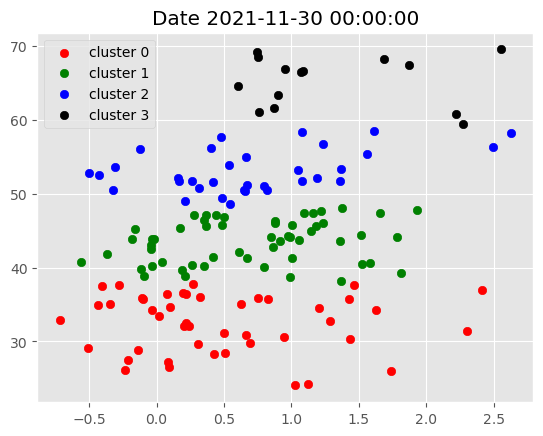

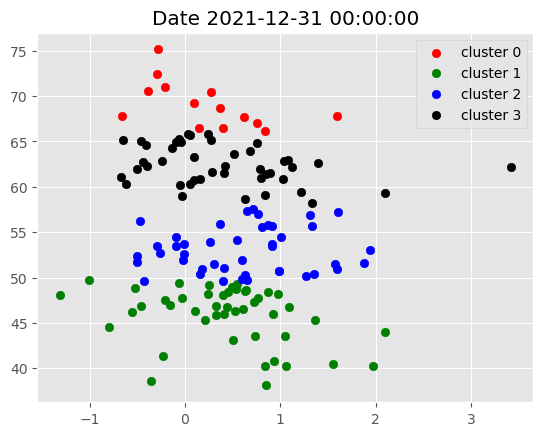

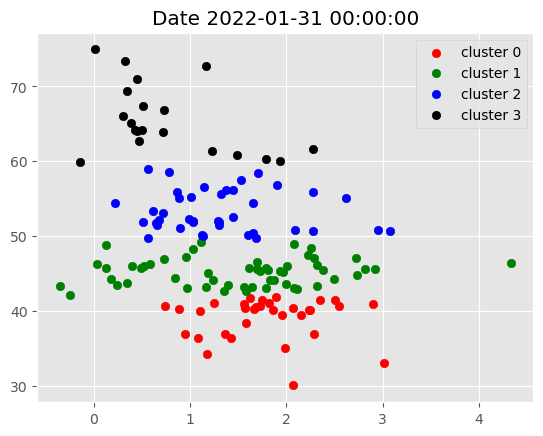

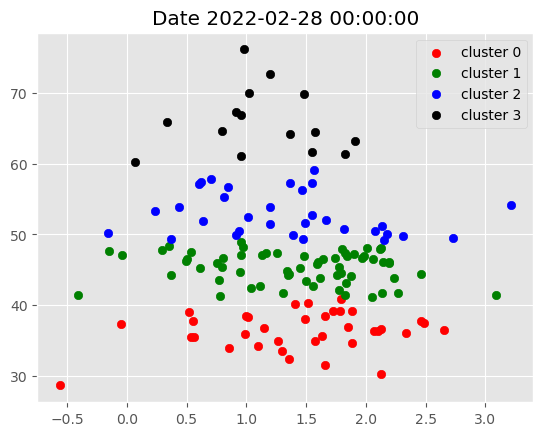

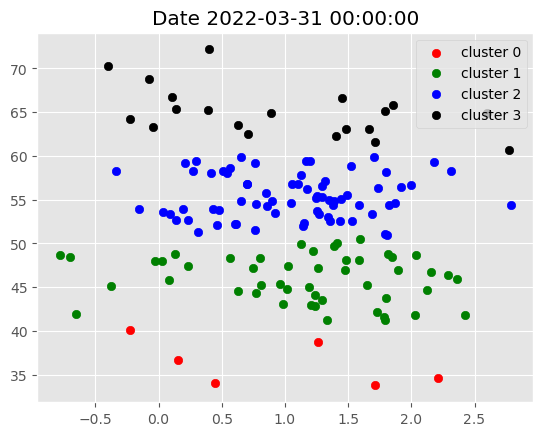

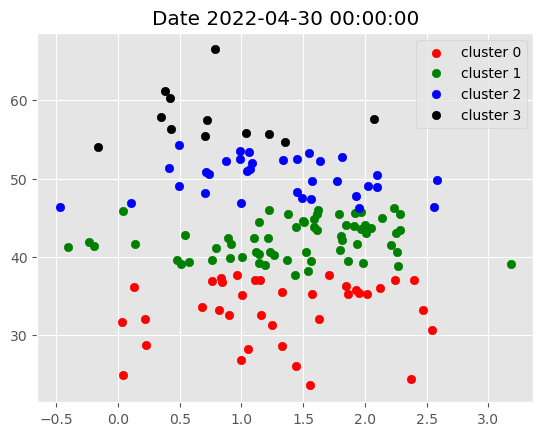

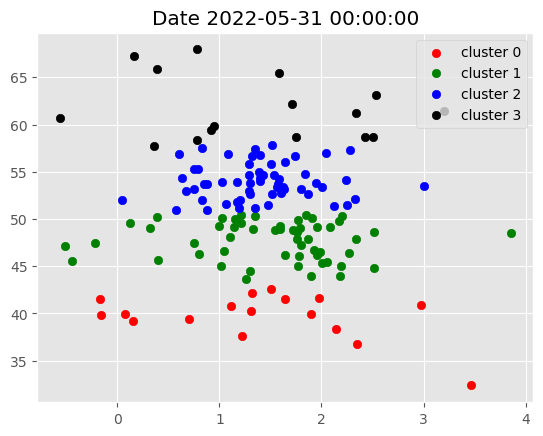

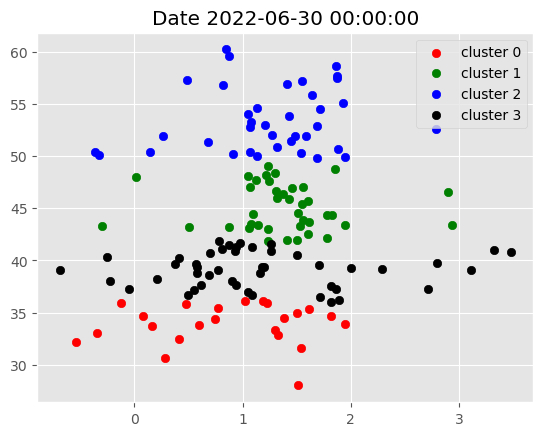

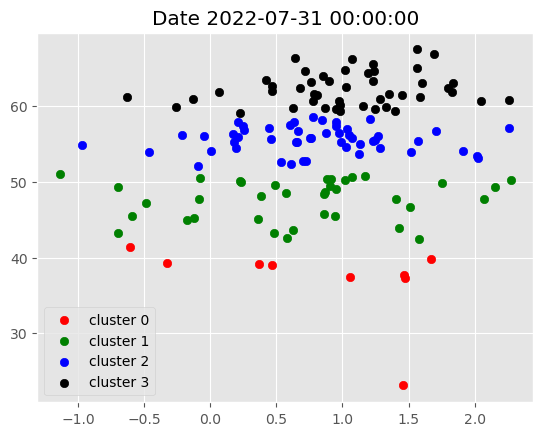

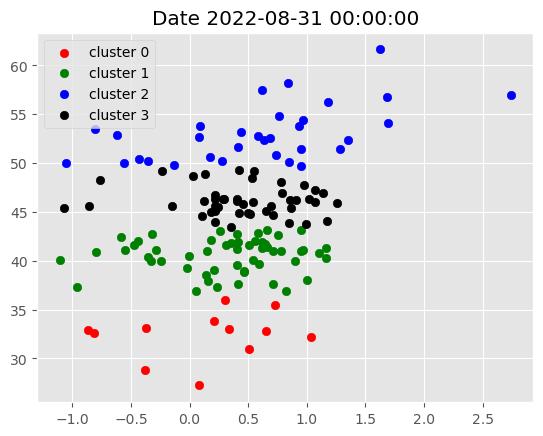

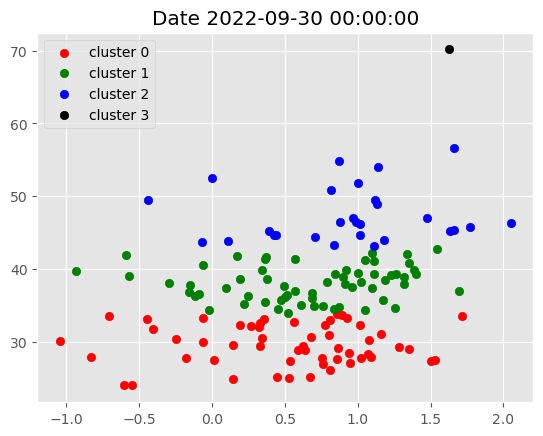

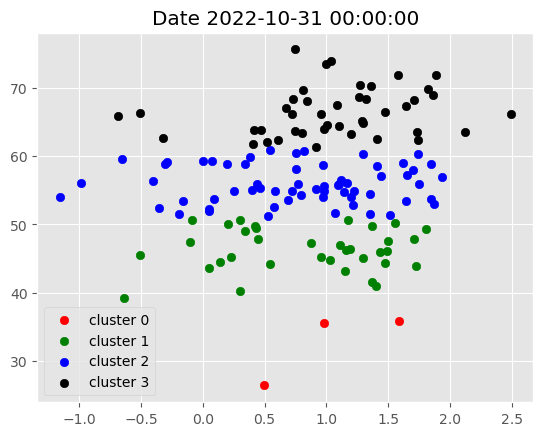

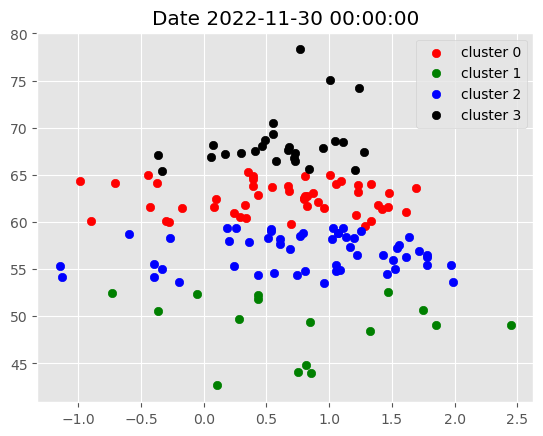

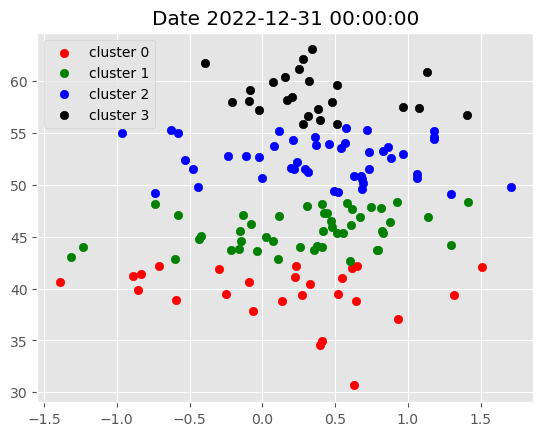

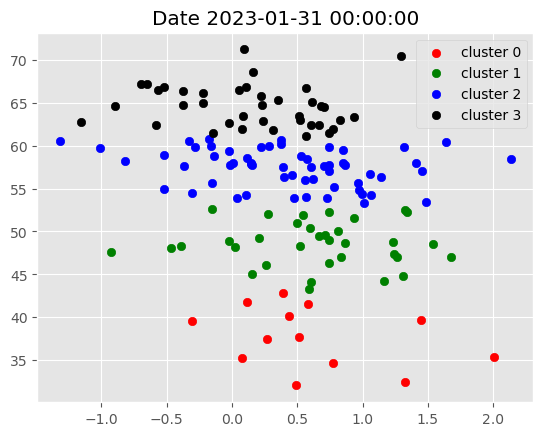

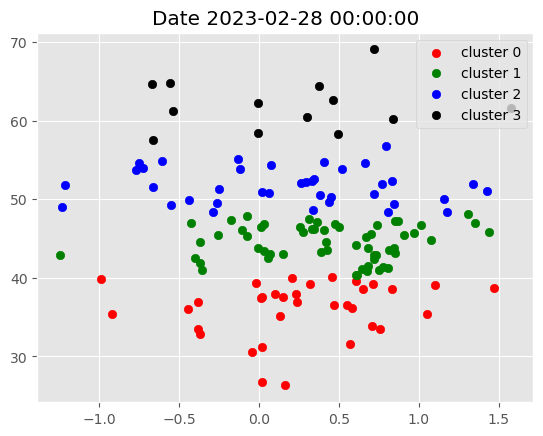

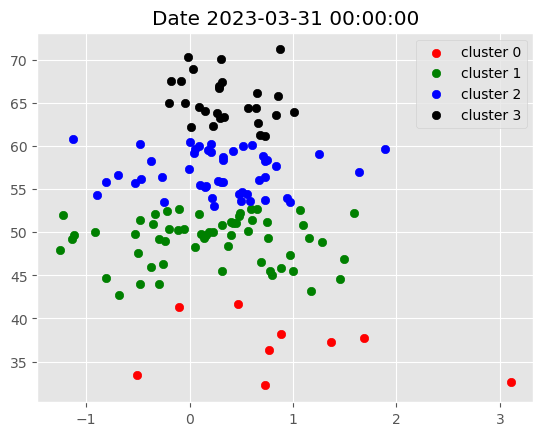

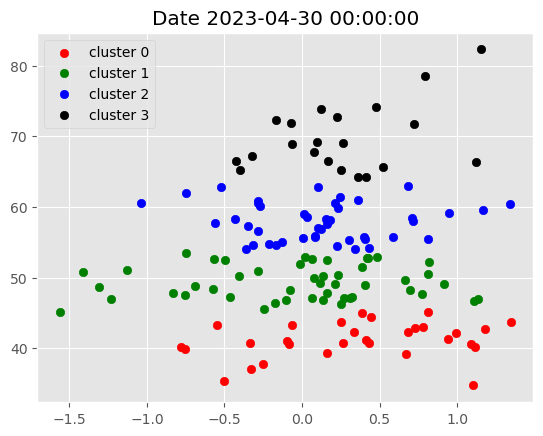

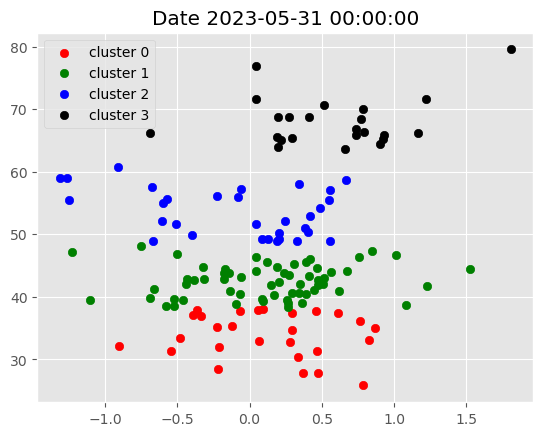

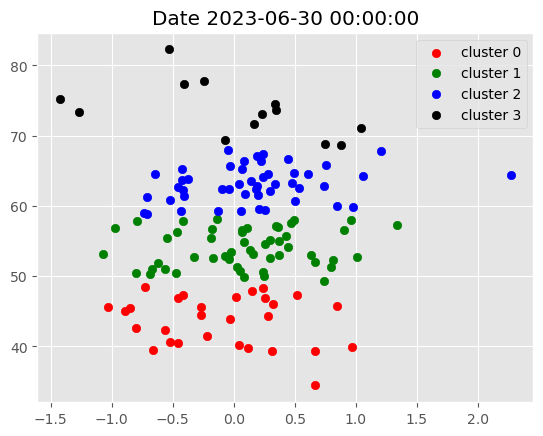

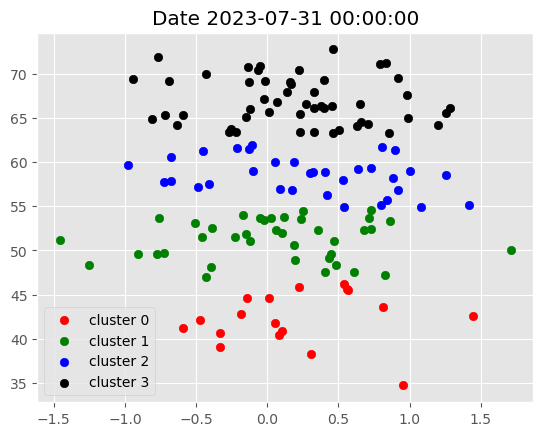

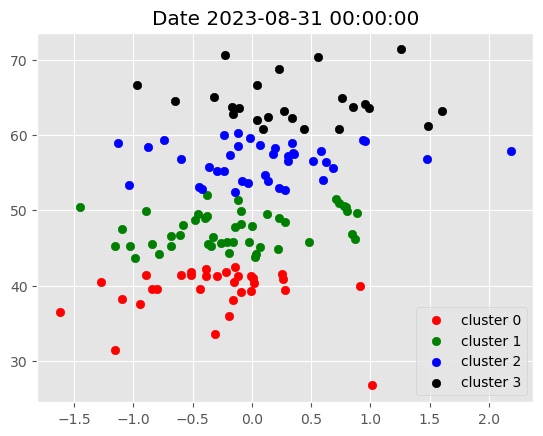

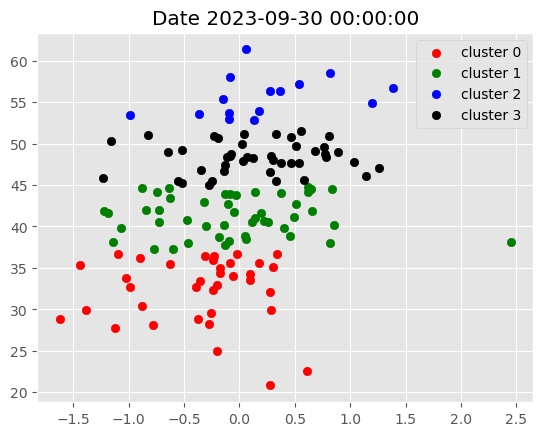

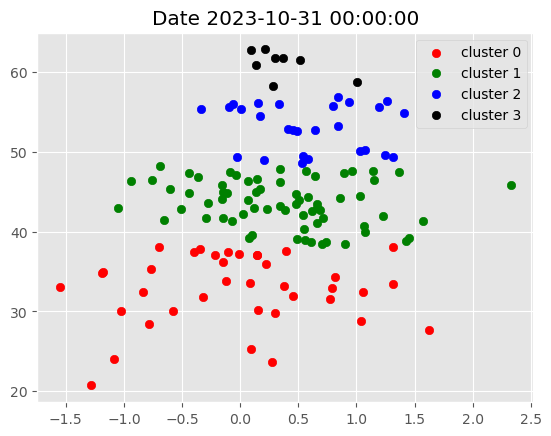

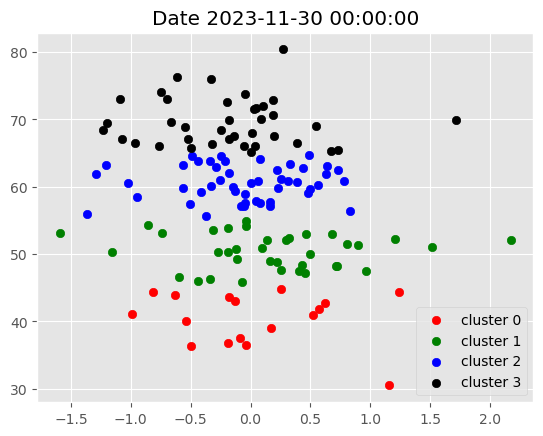

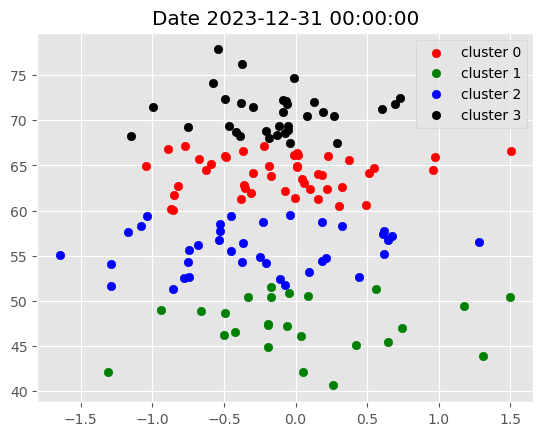

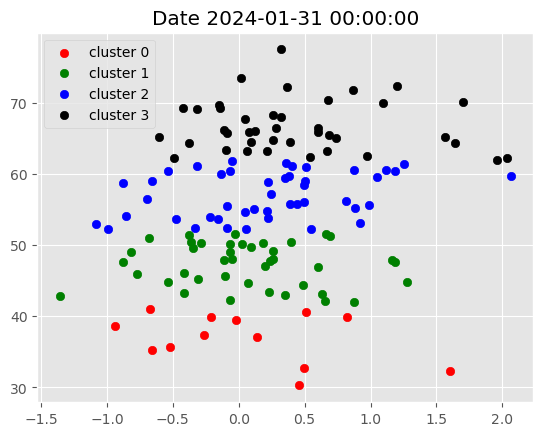

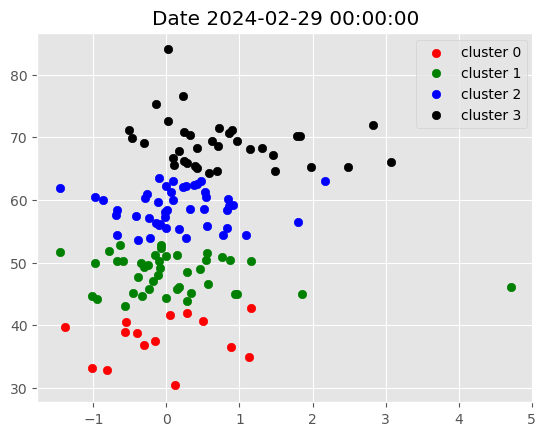

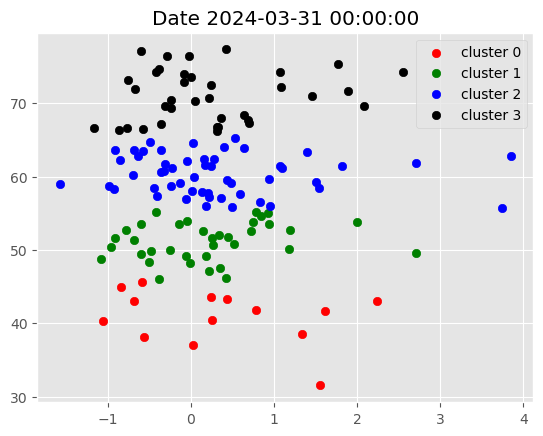

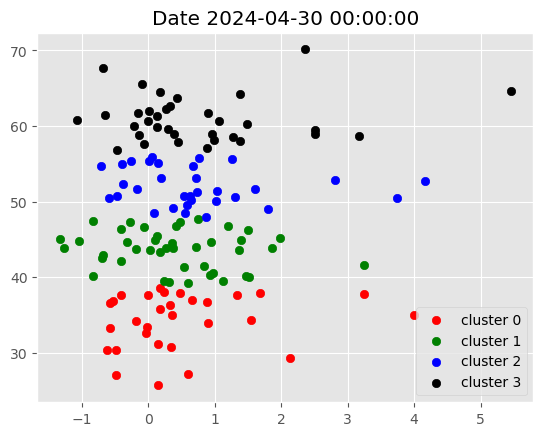

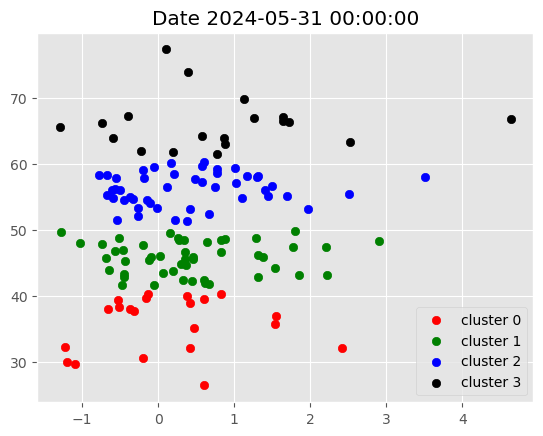

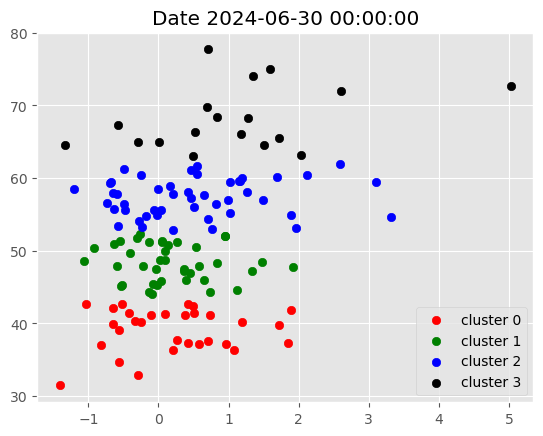

In [13]:
# 動画と指標の数値がぜんぜん違うので、多分カラム順番が間違っている
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)
    

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [14]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

# 日付が月の最終日になっているので+1日して月初に変えたい
filtered_df.index = filtered_df.index+pd.DateOffset(1)

# 日付と重みをもたせる
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

# 月ごとに投資するべき銘柄のリストを出力できる
fixed_dates

{'2018-07-01': ['ACN',
  'AMT',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'SPG',
  'TJX',
  'VZ'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BMY',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'SPG',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ADP',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'CVS',
  'DAL',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MDT',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'QCOM',
  'REGN',
  'SHW',
  'SPG',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNH',
  'V',
  'WMT'],
 '2018-10-01': ['ABT',
  'ADP',
  'AMD',
  'AMGN',
  'AVGO',
  'BA',
  'CAT',
  'CI',
  'COP',
  'CRM',
  'CSCO',
  'CVS',
  'DH

## Define portfolio optimization function
We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [17]:
# それぞれの銘柄にどれくらいの割合で投資すべきか重み付けをしたい
# 効率的フロンティア　（Efficient Frontier）とは、分散投資を実施したときに実現するポートフォリオの中で、あるリスクの水準で最大のリターンを獲得できるポートフォリオの集合のことを指す。

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    # sample_covは標本分散共分散行列です。
    # 分散共分散行列とは，分散（散らばり具合を表す指標）の概念を多次元確率変数に拡張して行列としたもの。データの散らばり具合や相関という情報を集約したものです！
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    # solver (string) – which SCIPY solver to use, e.g “SLSQP”, “COBYLA”, “BFGS”. User beware: different optimizers require different inputs.
    # シンプレックス法による制約ソルバー（本章では， SCS(simplex constraint solver) と呼ぶ）.
    # ソルバーについて(エクセルの記事だけど・・・)
    # エクセルのソルバー機能を使用して線形計画問題(Linear Problem)を解く方法について説明します。
    # 線形計画問題は、限られたリソースを最適に配分し、行動を最適化するための強力なツールです。そして、エクセルのソルバー機能を使えば、これらの問題を簡単に解くことができます。
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [18]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-06-30  48.838978   34.279442   57.334557   44.894611  115.219536   
2017-07-03  48.906921   34.155678   57.263386   44.986973  115.452423   
2017-07-05  49.751308   34.296112   57.310837   45.254803  115.564240   
2017-07-06  50.518059   33.972404   56.717808   44.275818  114.530159   
2017-07-07  51.469219   34.317524   56.955009   44.737610  115.713272   
...               ...         ...         ...         ...         ...   
2024-06-05  11.620000  195.869995  165.440002  103.230003  291.019989   
2024-06-06  11.430000  194.479996  168.570007  104.269997  291.739990   
2024-06-07  11.500000  196.889999  169.419998  107.580002  288.399994   
2024-06-10  11.490000  193.119995  170.460007  107.489998  290.429993   
2024-06-11  11.280000  207.149994  167.699997  105.809998  294.220001   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-06-30  141.440002   71.811943   94.026443  100.820000  54.970570  ...   
2017-07-03  138.410004   70.252022   93.989723   99.360001  55.647594  ...   
2017-07-05  141.210007   71.756554   95.503914  102.599998  55.199177  ...   
2017-07-06  140.750000   71.378120   94.925774  102.050003  55.462959  ...   
2017-07-07  142.220001   72.430389   96.485847  103.320000  55.700348  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-05  455.799988  235.679993  245.779999  216.279999  75.900002  ...   
2024-06-06  458.130005  237.410004  247.970001  215.869995  75.620003  ...   
2024-06-07  465.429993  234.770004  252.320007  216.050003  76.019997  ...   
2024-06-10  459.940002  235.369995  246.869995  218.199997  76.019997  ...   
2024-06-11  462.690002  236.300003  246.580002  211.500000  74.209999  ...   

Price        Volume                                                          \
Ticker            V      VLO     VRTX        VZ      WBA      WDC       WFC   
Date                                                                          
2017-06-30  9036600  2972000  1582300  13368900  7097300  6614900  16750700   
2017-07-03  6197700  2160000   825200   9732000  2419200  4562300  11825000   
2017-07-05  9339600  3938100  1320600  14853400  6481000  5119800  14086900   
2017-07-06  8215700  3332100  1171800  16854300  6011600  4143800  14481200   
2017-07-07  6175800  5083600  1019900  12198500  6001900  3436800  11503500   
...             ...      ...      ...       ...      ...      ...       ...   
2024-06-05  5368700  1939200  1196600  11964000  8949000  5501300  11199100   
2024-06-06  4862400  1981000  1263600  10259100  7163300  3877500  18587400   
2024-06-07  4515600  1979600   944300  10410200  8431800  5640300  14466700   
2024-06-10  5213800  2285300  1253800  15214000  9607600  6080900  12793800   
2024-06-11  6198850  2082830   830973  12047619  7025411  3550601  18438708   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-06-30  20889900  1455000  14000600  
2017-07-03  14545800  2005600   8422300  
2017-07-05  18110700  1212300   9830800  
2017-07-06  18485400  1276900   9822400  
2017-07-07  15921300  1334800  10777800  
...              ...      ...       ...  
2024-06-05  14982700  1335000  14863500  
2024-06-06  13256000  1194600  13154100  
2024-06-07  20213200  1416200  13289200  
2024-06-10  21667400  1395500  15245200  
2024-06-11  13327482  1933040  12413991  

[1748 rows x 930 columns]

In [19]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:
    
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
    
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d') 

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False

        try:
    
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))
        
            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print('Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
                   
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        # [Date, Index]だとエラーになるので、[Date, Ticker]にした
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()
        
        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df


Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-07-02,0.002609
2018-07-03,-0.006577
2018-07-05,0.009274
2018-07-06,0.008924
2018-07-09,0.001269
...,...
2024-06-05,0.012312
2024-06-06,-0.001185
2024-06-07,-0.000559


In [ ]:
# # len(optimization_df.columns)が動画では１０になるのに自分でやると５３になるのはなぜ
# weights = optimize_weights(prices=optimization_df,
#                            lower_bound=round(1/(len(optimization_df.columns)*2),3))
# weights = pd.DataFrame(weights, index=pd.Series(0))

# エラーになる
# temp_df = returns_dataframe['2017-11-01':'2017-11-30']

# temp_df.stack().to_frame('return').reset_index(level=0)\
#     .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
#           left_index=True,
#           right_index=True)\
#     .reset_index().set_index(['Date', 'index']).unstack().stack()

# 8. Visualize Portfolio returns and compare to SP500 returns.

In [20]:
spy = yf.download(tickers='SPY',
                 start='2015-01-01',
                 end=dt.date.today())
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY BuyHold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                 left_index=True,
                                 right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY BuyHold
2018-07-02,0.002609,0.002136
2018-07-03,-0.006577,-0.003538
2018-07-05,0.009274,0.008125
2018-07-06,0.008924,0.008423
2018-07-09,0.001269,0.008964
...,...,...
2024-06-05,0.012312,0.011815
2024-06-06,-0.001185,-0.000019
2024-06-07,-0.000559,-0.001216
2024-06-10,0.005180,0.003085


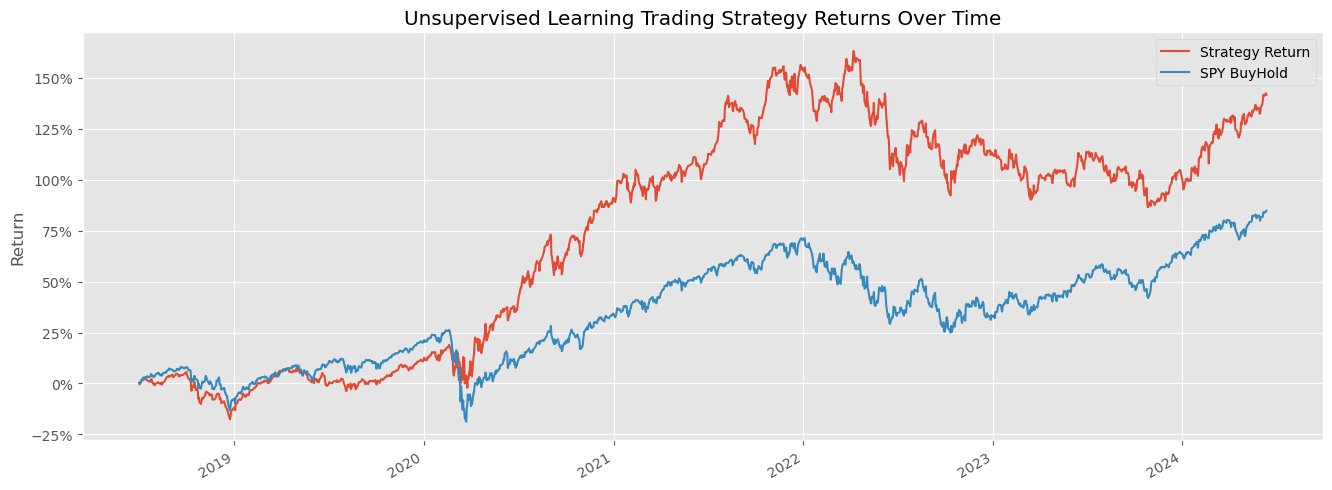

In [21]:
# 負けとるやん
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-06-11'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()